In [1]:
pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 104.1 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

import keras
import tensorflow_hub as hub
import tensorflow_text as text

In [3]:
import pandas as pd
import numpy as np

In [5]:
# setting A
df_train = pd.read_csv('TR_a.csv')
df_train=df_train.rename(columns={"gold_adj": "gold"})

df_dev = pd.read_csv('TD_a.csv')
df_dev=df_dev.rename(columns={"gold_adj": "gold"})

df_test = pd.read_csv('TE_a.csv')
df_test=df_test.rename(columns={"gold_adj": "gold"})

In [6]:
df_test['gold'].value_counts()

y     212
n     157
uk     80
py     49
pn     29
Name: gold, dtype: int64

In [7]:
y = pd.get_dummies(df_train.gold, prefix='gold')
y

,gold_n,gold_pn,gold_py,gold_uk,gold_y
0,0,0,0,0,1
1,0,0,0,0,1
2,1,0,0,0,0
3,1,0,0,0,0
4,0,0,0,0,1
...,...,...,...,...,...
3310,0,0,1,0,0
3311,1,0,0,0,0
3312,1,0,0,0,0
3313,0,0,0,1,0


In [8]:
y_dev = pd.get_dummies(df_dev.gold, prefix='gold')
y_dev

,gold_n,gold_pn,gold_py,gold_uk,gold_y
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,1,0,0,0,0
4,0,0,0,0,1
...,...,...,...,...,...
595,1,0,0,0,0
596,0,0,1,0,0
597,0,0,0,1,0
598,0,0,1,0,0


Roberta Init

In [9]:
# Changed to roberta

bert_preprocess = hub.KerasLayer("https://tfhub.dev/jeongukjae/roberta_en_cased_preprocess/1", trainable=True)
bert_encoder = hub.KerasLayer("https://tfhub.dev/jeongukjae/roberta_en_cased_L-12_H-768_A-12/1", trainable=True)

In [10]:
# RoBerta layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text') # Textual input layer
preprocessed_text = bert_preprocess(text_input) # The preprocessing of text
outputs = bert_encoder(preprocessed_text) # Encoded o/p

# Neural network layers
# l = tf.keras.layers.Dense(50, activation='sigmoid', name="output")(outputs['pooled_output'])
# l = tf.keras.layers.Dense(6, activation='softmax', name="soft_output")(l)

l = tf.keras.layers.Dense(5, activation='softmax', name="soft_output")(outputs['pooled_output'])

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.


In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [12]:
import keras

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.learning_rate # I use ._decayed_lr method instead of .lr
    return lr


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.01, restore_best_weights=True)

initial_learning_rate = 0.00003
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

lr_metric = get_lr_metric(optimizer)

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      lr_metric
]

# optimizer.learning_rate.assign(0.00002)
model.compile(optimizer=optimizer,
              loss='CategoricalCrossentropy',
              metrics=METRICS)

In [13]:
model.fit(df_train['Reply_tweet'], y, epochs=200, batch_size=16, callbacks=[callback], validation_data=(df_dev['Reply_tweet'], y_dev))

Epoch 1/200
208/208 [==============================] - 227s 1s/step - loss: 1.2534 - accuracy: 0.4531 - precision: 0.6949 - recall: 0.1807 - lr: 3.0000e-05 - val_loss: 1.0937 - val_accuracy: 0.5483 - val_precision: 0.7937 - val_recall: 0.2950 - val_lr: 3.0000e-05
Epoch 2/200
208/208 [==============================] - 209s 1s/step - loss: 1.0080 - accuracy: 0.5861 - precision: 0.7671 - recall: 0.3964 - lr: 3.0000e-05 - val_loss: 1.0659 - val_accuracy: 0.5417 - val_precision: 0.6918 - val_recall: 0.3817 - val_lr: 3.0000e-05
Epoch 3/200
208/208 [==============================] - 209s 1s/step - loss: 0.8437 - accuracy: 0.6549 - precision: 0.7721 - recall: 0.5294 - lr: 3.0000e-05 - val_loss: 1.0749 - val_accuracy: 0.5933 - val_precision: 0.6889 - val_recall: 0.4650 - val_lr: 3.0000e-05
Epoch 4/200
208/208 [==============================] - 209s 1s/step - loss: 0.6328 - accuracy: 0.7566 - precision: 0.8206 - recall: 0.6817 - lr: 3.0000e-05 - val_loss: 1.3004 - val_accuracy: 0.5617 - val_prec

Dev set

In [14]:
y_dev = pd.get_dummies(df_dev.gold, prefix = 'gold')
print(model.evaluate(df_dev['Reply_tweet'], y_dev))
y_predicted = model.predict(df_dev['Reply_tweet'])

pred_results = tf.cast(tf.equal(y_predicted, tf.reduce_max(y_predicted, axis = 1, keepdims=True)), tf.float32)

pred_results = pd.DataFrame(pred_results.numpy(), columns = ['gold_n', 
                                       'gold_pn',
                                       'gold_py',                     	
                                       'gold_uk',	
                                       'gold_y'])

pred_results.shape
pred_results.to_numpy()
pred_results = [np.where(r==1)[0][0] for r in pred_results.to_numpy()]
pred_results = pd.DataFrame(pred_results, columns=['gold'])

pred_results['gold'] = pred_results['gold'].map({0:'n', 
                                                   1:'pn',
                                                   2:'py',
                                                   3:'uk',
                                                   4:'y'})

dev_gtruths = [np.where(r==1)[0][0] for r in y_dev.to_numpy()]
dev_gtruths = pd.DataFrame(dev_gtruths, columns=['gold'])

dev_gtruths['gold'] = dev_gtruths['gold'].map({0:'n', 
                                                   1:'pn',
                                                   2:'py',
                                                   3:'uk',
                                                   4:'y'})

print('DEV')
from sklearn.metrics import classification_report
print(classification_report(y_true = dev_gtruths['gold'], y_pred = pred_results['gold']))

19/19 [==============================] - 9s 488ms/step - loss: 1.0659 - accuracy: 0.5417 - precision: 0.6918 - recall: 0.3817 - lr: 3.0000e-05
[1.0658618211746216, 0.5416666865348816, 0.6918429136276245, 0.3816666603088379, 2.9999999242136255e-05]
19/19 [==============================] - 9s 470ms/step
DEV
              precision    recall  f1-score   support

           n       0.45      0.72      0.55       166
          pn       0.50      0.05      0.10        19
          py       0.47      0.46      0.46        61
          uk       0.76      0.25      0.37       113
           y       0.63      0.61      0.62       241

    accuracy                           0.54       600
   macro avg       0.56      0.42      0.42       600
weighted avg       0.58      0.54      0.52       600



Test Set

In [15]:
df_test= df_test.rename(columns={"gold_adj": "gold"})
y_test = pd.get_dummies(df_test.gold, prefix = 'gold')
print(model.evaluate(df_test['Reply_tweet'], y_test))
y_predicted = model.predict(df_test['Reply_tweet'])

pred_results = tf.cast(tf.equal(y_predicted, tf.reduce_max(y_predicted, axis = 1, keepdims=True)), tf.float32)

pred_results = pd.DataFrame(pred_results.numpy(), columns = ['gold_n', 
                                       'gold_pn',
                                       'gold_py',                     	
                                       'gold_uk',	
                                       'gold_y'])

pred_results.shape
pred_results.to_numpy()
pred_results = [np.where(r==1)[0][0] for r in pred_results.to_numpy()]
pred_results = pd.DataFrame(pred_results, columns=['gold'])

pred_results['gold'] = pred_results['gold'].map({0:'n', 
                                                   1:'pn',
                                                   2:'py',
                                                   3:'uk',
                                                   4:'y'})

test_gtruths = [np.where(r==1)[0][0] for r in y_test.to_numpy()]
test_gtruths = pd.DataFrame(test_gtruths, columns=['gold'])

test_gtruths['gold'] = test_gtruths['gold'].map({0:'n', 
                                                   1:'pn',
                                                   2:'py',
                                                   3:'uk',
                                                   4:'y'})

print('TEST')
from sklearn.metrics import classification_report
print(classification_report(y_true = test_gtruths['gold'], y_pred = pred_results['gold']))

17/17 [==============================] - 8s 485ms/step - loss: 1.1414 - accuracy: 0.5560 - precision: 0.6845 - recall: 0.4118 - lr: 3.0000e-05
[1.1413651704788208, 0.5559772253036499, 0.6845425963401794, 0.4117647111415863, 2.9999999242136255e-05]
17/17 [==============================] - 8s 465ms/step
TEST
              precision    recall  f1-score   support

           n       0.48      0.71      0.58       157
          pn       0.60      0.10      0.18        29
          py       0.40      0.29      0.33        49
          uk       0.65      0.21      0.32        80
           y       0.64      0.69      0.67       212

    accuracy                           0.56       527
   macro avg       0.56      0.40      0.41       527
weighted avg       0.57      0.56      0.53       527



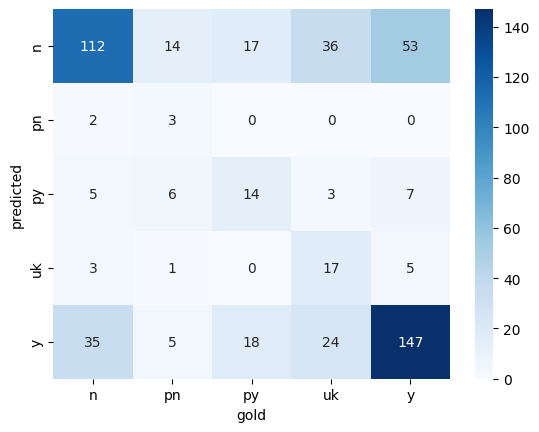

gold         n  pn  py  uk    y
predicted                      
n          112  14  17  36   53
pn           2   3   0   0    0
py           5   6  14   3    7
uk           3   1   0  17    5
y           35   5  18  24  147


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

confusion_matrix = pd.crosstab(pred_results['gold'],test_gtruths['gold'],rownames=['predicted'], colnames=['gold'])

sns.heatmap(confusion_matrix,annot=True,cmap='Blues', fmt='g')
plt.show()
print(confusion_matrix)

In [17]:
pred_results = pred_results.rename(columns={"gold": "predict"})
pred_results['Main_Tweet_ID'] = df_test['Main_Tweet_ID']
pred_results['Reply_id'] = df_test['Reply_id']

In [18]:
pred_results['predict'].value_counts()

n     232
y     229
py     35
uk     26
pn      5
Name: predict, dtype: int64

In [19]:
pred_results

,predict,Main_Tweet_ID,Reply_id
0,py,1505591204783734785,1505605176140472320
1,uk,1471985146891059206,1471985474621173763
2,n,1465064127399870467,1465229350660284417
3,y,1524647970611863553,1524648652886757376
4,y,1506565419313868802,1506577193626918918
...,...,...,...
522,n,1532024495308939265,1532030543788916737
523,y,1471985146891059206,1471985557656031235
524,n,1451009236423565312,1451015270584233985
525,y,1426184209153118214,1426312272079736832


In [20]:
pred_results.to_csv('/content/drive/MyDrive/expts_emnlp23/results/A_twiiter_a.csv')